<a href="https://colab.research.google.com/github/RegaipKURT/Machine-Learning-Python/blob/master/Forecasting_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [0]:
!pip3 install arch yfinance pmdarima

In [0]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [4]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2020-04-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [0]:
df_comp = raw_data.copy()

In [0]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [0]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Creating Returns

In [0]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [0]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [0]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [0]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [12]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-12-26,2088.770020,9922.110352,6598.200195,17818.960938,0.330957,0.000000,0.000000,0.057337,-137.979243,-0.000000,0.000000,25.292295
2014-12-29,2090.570068,9927.129883,6633.500000,17729.839844,0.086177,0.534991,0.050589,-0.500148,-35.928182,-68.682394,36.308955,-220.624734
2014-12-30,2080.350098,9805.549805,6547.000000,17450.769531,-0.488860,-1.303987,-1.224725,-1.574015,203.810478,167.406373,-879.009066,-694.328341
2014-12-31,2058.899902,9805.549805,6547.000000,17450.769531,-1.031086,0.000000,0.000000,0.000000,429.869279,-0.000000,0.000000,0.000000
2015-01-01,2058.899902,9805.549805,6547.000000,17450.769531,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000


In [0]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-15"
end_date = "2020-03-31"

In [0]:
end_date = "2020-03-31"
df_pred = results_ar.predict(start = start_date, end = end_date)

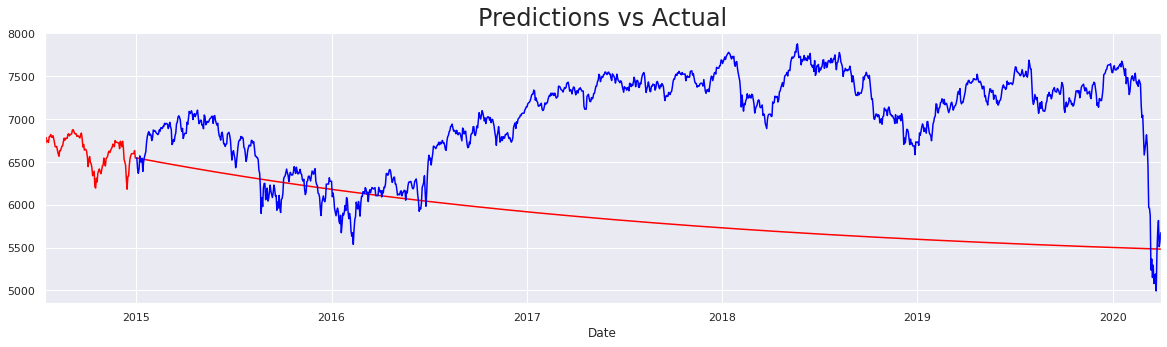

In [57]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Using Returns Instead

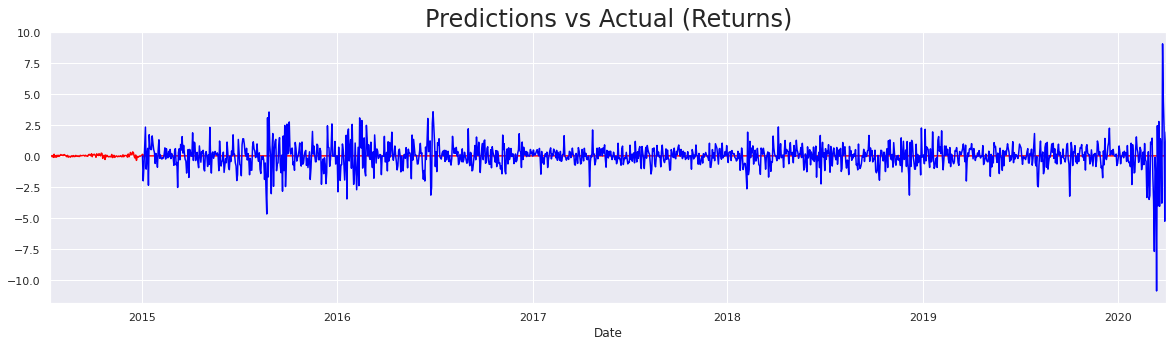

In [58]:
end_date = "2020-03-31"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [46]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5473
Model:                     ARMA(5, 0)   Log Likelihood               -8468.533
Method:                       css-mle   S.D. of innovations              1.137
Date:                Thu, 02 Apr 2020   AIC                          16951.066
Time:                        01:52:35   BIC                          16997.319
Sample:                    01-11-1994   HQIC                         16967.203
                         - 01-01-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0184      0.013      1.396      0.163      -0.007       0.044
ar.L1.ret_ftse    -0.0217      0.013     -1.607      0.108      -0.048       0.005
ar.L2.ret_ftse    -0.0527      0.013     -3.906      0.000      -0.079      -0.026
ar.L3.ret_ftse    -0.0773      0.013     -5.742      0.000      -0.104      -0.051
ar.L4.ret_ftse     0.0414      0.013      3.070      0.002       0.015       0.068
ar.L5.ret_ftse    -0.0567      0.013     -4.202      0.000      -0.083      -0.030
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5715           -0.0000j            1.5715           -0.5000
AR.2           -0.2993           -1.7410j            1.7665           -0.2771
AR.3           -0.2993           +1.7410j            1.7665            0.2771
AR.4            1.4502           -1.2220j            1.8964           -0.1114
AR.5            1.4502           +1.2220j            1.8964            0.1114
-----------------------------------------------------------------------------
"""

### MA

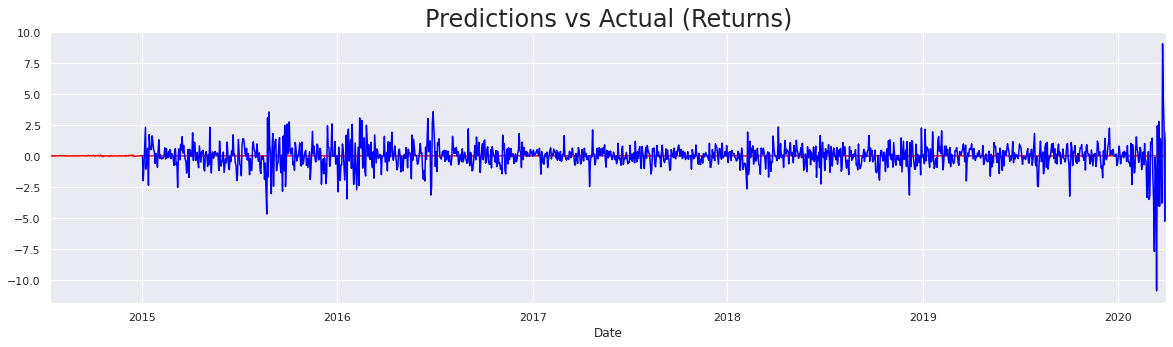

In [47]:
end_date = "2020-03-31"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [48]:
df_pred_ma.head()

2014-07-15   -0.002352
2014-07-16    0.031509
2014-07-17   -0.008660
2014-07-18    0.035273
2014-07-21    0.015028
Freq: B, dtype: float64

### ARMA

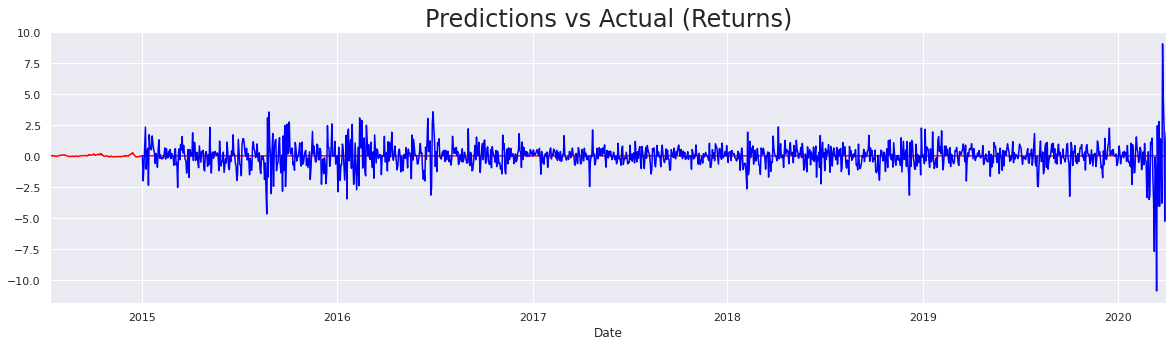

In [49]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [50]:
df_pred_arma.head()

2014-07-15    0.026441
2014-07-16    0.050075
2014-07-17   -0.005413
2014-07-18    0.030999
2014-07-21    0.021985
Freq: B, dtype: float64

In [51]:
df_pred_arma.tail()

2020-03-25    0.01835
2020-03-26    0.01835
2020-03-27    0.01835
2020-03-30    0.01835
2020-03-31    0.01835
Freq: B, dtype: float64

### ARMAX

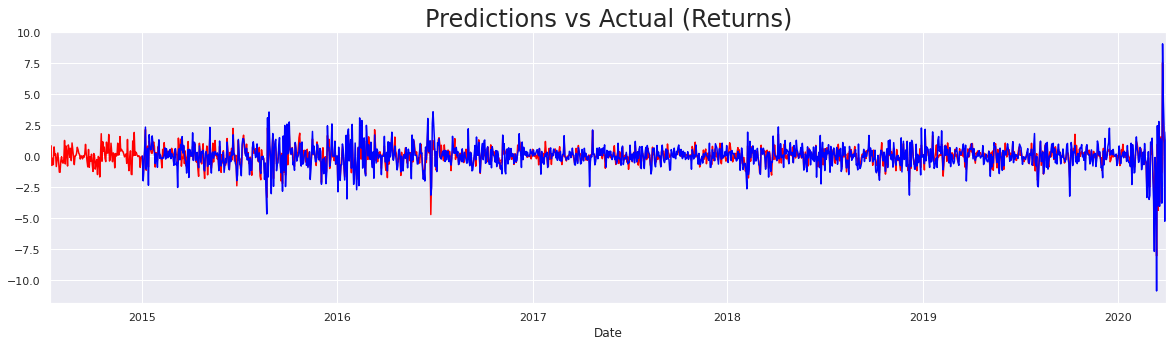

In [52]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

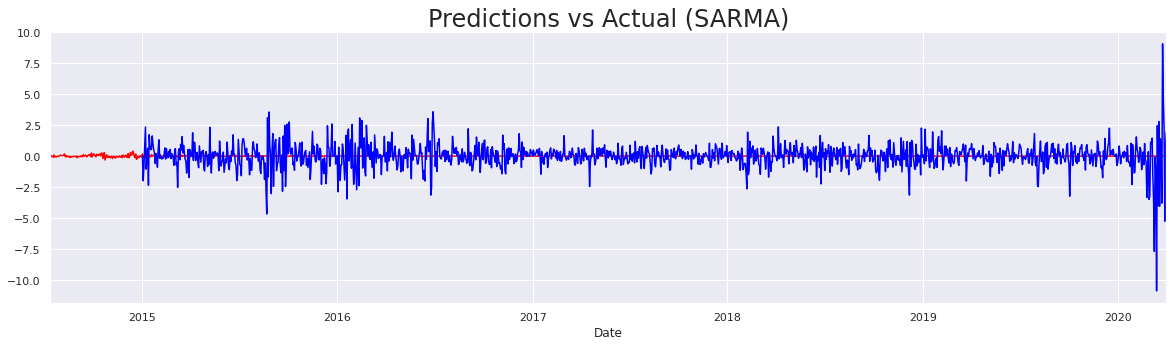

In [53]:
end_date = "2020-03-31"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

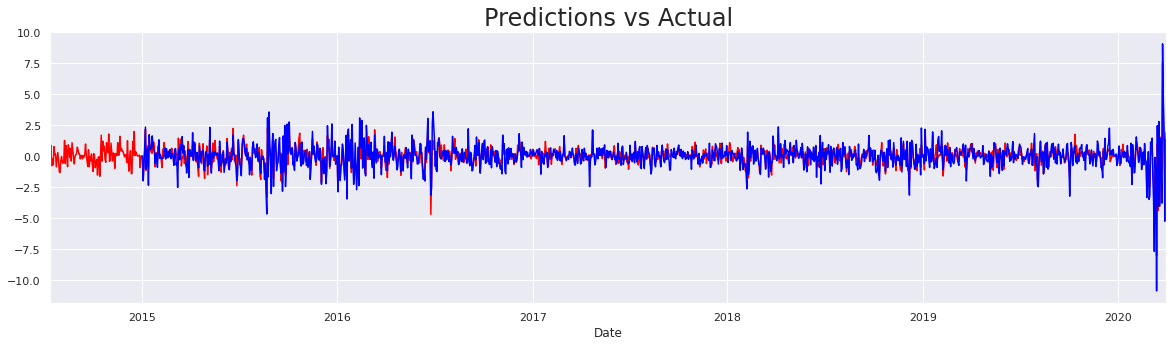

In [54]:
end_date = "2020-03-31"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [0]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [0]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

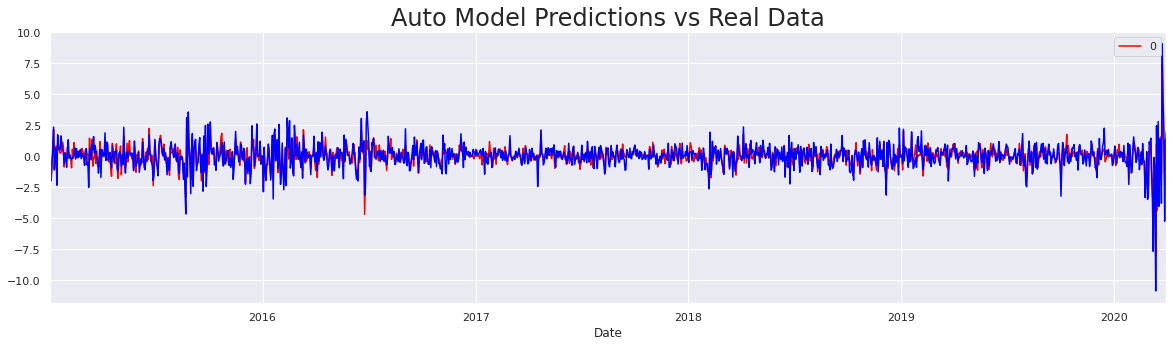

In [30]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

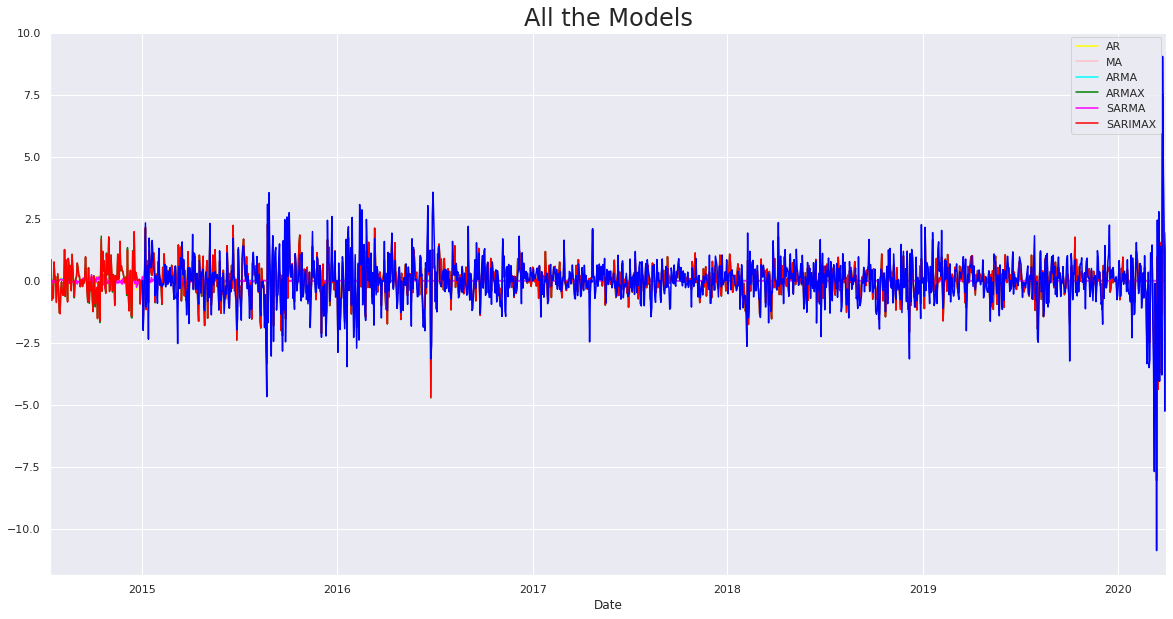

In [55]:
end_date = "2020-03-31"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [32]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7310.1880654267625
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7310.187341157432
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [0]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

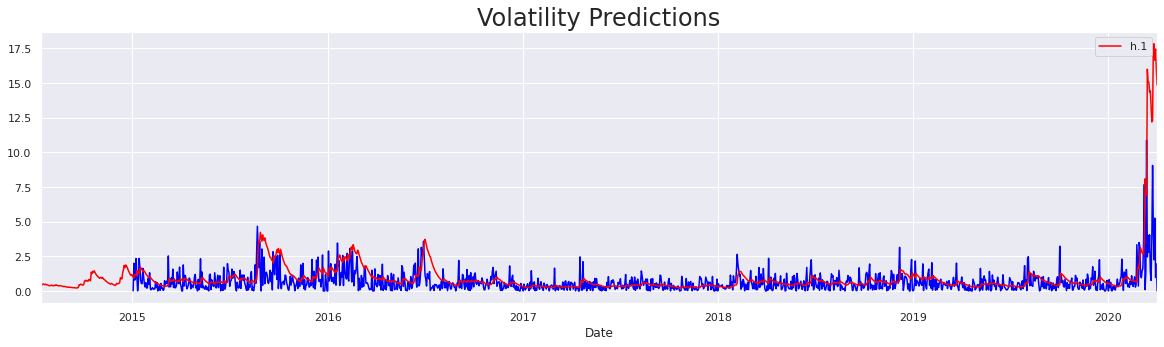

In [34]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [35]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,14.865303,15.870005,17.208656,16.29626,17.32855,17.205049,11.818499,11.621304,12.607756,13.571922,13.390264,13.955892,13.854698,14.6096,6.344572,6.730714,7.315895,3.27033,2.50223,2.496443,2.550919,2.698269,2.831738,2.289397,1.543529,1.653578,1.491391,0.772043,0.801103,0.841671,0.825318,0.835852,0.878993,0.904211,0.86852,0.905839,0.928383,0.975425,1.01209,1.067398,...,0.779244,0.804146,0.806555,0.830902,0.825913,0.852839,0.860098,0.854818,0.88199,0.911738,0.943605,0.977639,1.001654,1.039804,1.073237,1.115673,1.16263,0.971317,0.949748,0.953101,0.983617,1.011382,1.045383,0.992186,0.997946,1.023627,0.909444,0.898008,0.875397,0.892406,0.908252,0.929453,0.916013,0.876575,0.887639,0.871757,0.886242,0.902896,0.920245,0.909611


### Multvariate Regression Model

In [0]:
from statsmodels.tsa.api import VAR

In [0]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [0]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [39]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Apr, 2020
Time:                     01:52:30
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.347064
Nobs:                     5465.00    HQIC:                  0.243175
Log likelihood:          -31398.3    FPE:                    1.20623
AIC:                     0.187502    Det(Omega_mle):         1.17753
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.041768         0.015880            2.630           0.009
L1.ret_spx           -0.110191         0.017352           -6.350           0.000
L1.ret_dax            0.063072         0.018763           

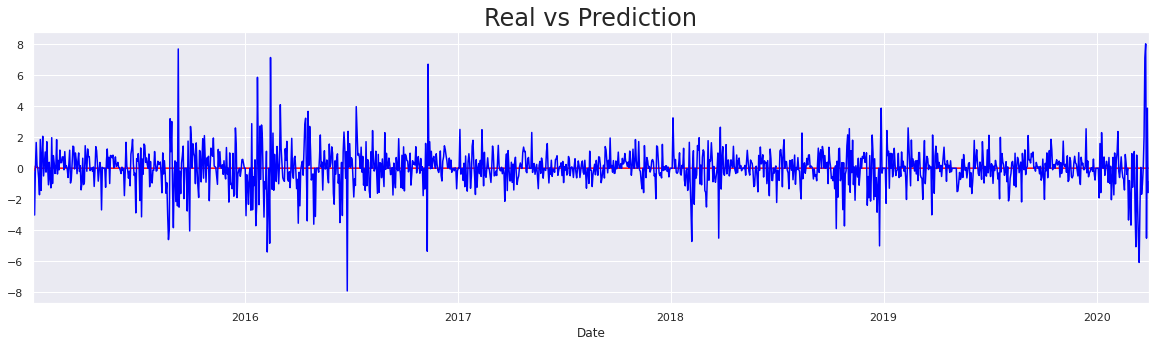

In [59]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

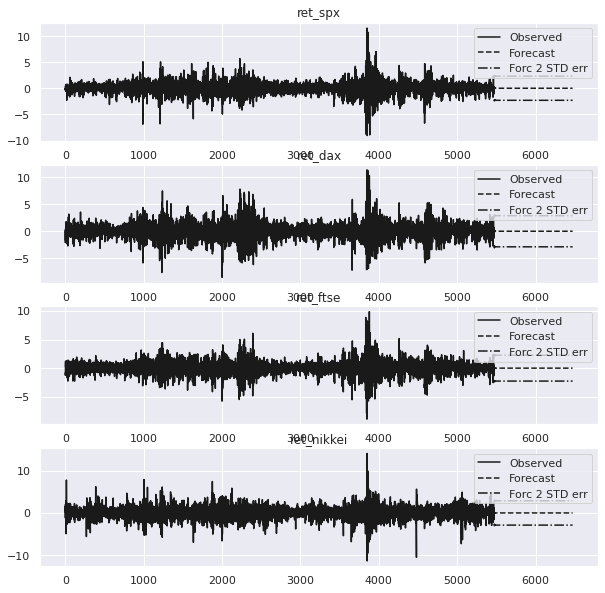

In [62]:
results_var_ret.plot_forecast(1000)
plt.show()